# "Feature Importance Analysis for Predicting Online Shoppers’ Purchasing Intent"
#### MATH 457 - Statistical Learning, Binghamton University
#### Kathryn AuClair, Kristina Donders, and Kira Liang
#### 11/14/2025

[Dataset via UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
shoppers = pd.read_csv("/content/online_shoppers_intention.csv")

## Preliminary Studies:

### Encode categorical features with one-hot encoding:

One-hot encoding is a process for converting categorical data into a numerical format that machine learning algorithms can process. It creates new binary (0 or 1) columns for each category in the original feature, with a '1' indicating the presence of that category and '0' indicating its absence.


In [ ]:
# Categorical:
categorical_cols = [
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "VisitorType",
    "Weekend",
    "Month"
]

# Numerical:
numeric_cols = [
    "Administrative", "Administrative_Duration",
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues"
]

#one-hot encoding:
df_enc = pd.get_dummies(shoppers, columns=categorical_cols, drop_first=True)

# print(df_enc.head())

### Scaled numerical features using z-score standardization:

Z-score standardization is a statistical technique that transforms data into a standard normal distribution. It expresses each data point as the number of standard deviations it is away from the mean.

In [ ]:
# Initialize the scaler:
scaler = StandardScaler()

# Fit + transform the numeric columns:
shoppers[numeric_cols] = scaler.fit_transform(shoppers[numeric_cols])

# Check scaled data:
print(shoppers[numeric_cols].describe().round(2))


       Administrative  Administrative_Duration  Informational  \
count        12330.00                 12330.00        12330.0   
mean            -0.00                     0.00           -0.0   
std              1.00                     1.00            1.0   
min             -0.70                    -0.46           -0.4   
25%             -0.70                    -0.46           -0.4   
50%             -0.40                    -0.41           -0.4   
75%              0.51                     0.07           -0.4   
max              7.43                    18.77           18.5   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count                12330.00        12330.00                 12330.00   
mean                    -0.00            0.00                    -0.00   
std                      1.00            1.00                     1.00   
min                     -0.24           -0.71                    -0.62   
25%                     -0.24           -0.5

### Split into train and test data (70% train, 30% test)

We are using revenue as the variable we are predicting because that show whether a person bought something or not

In [ ]:
# Separate features and target (revenue is target):
X = df_enc.drop("Revenue", axis=1)
y = shoppers["Revenue"]

# Split 70% train, 30% test, keeping imbalance:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Check the class balance (make sure it's still about 15%):
print("Train positive ratio:", y_train.mean())
print("Test positive ratio:", y_test.mean())


Train positive ratio: 0.15479087011933726
Test positive ratio: 0.15463638821303055


### Handing class imbalance:

Professors note: Imbalance: ~15% positives—use PR-AUC or F1 as primary metrics.

SMOTE creates synthetic examples of the minority class (purchasers).

Model A: imbalanced

Model B: SMOTE (oversampling)

In [ ]:
# Scale numerics: fit on train, transforms both:
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols])

# Version A (imbalanced):
X_train_A = X_train_scaled
y_train_A = y_train.copy()

# Version B (SMOTE):
smote = SMOTE(random_state=42)
X_train_B, y_train_B = smote.fit_resample(X_train_scaled, y_train)

### Correlation heatmap between numeric variables:

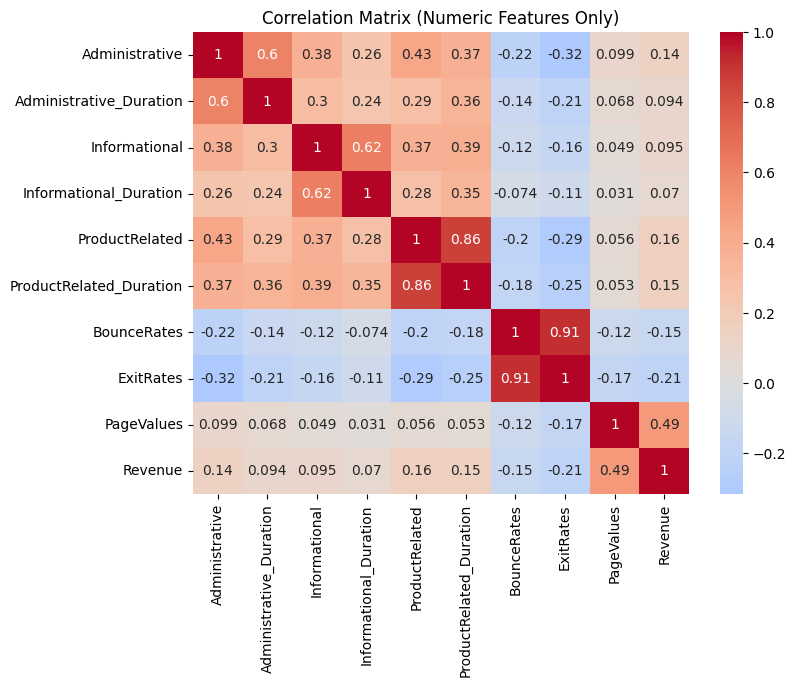

In [ ]:
num_cols = [
    "Administrative", "Administrative_Duration", "Informational",
    "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues", "Revenue"
]

plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[num_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()


The correlation matrix reveals strong positive relationships between features that measure similar browsing behaviors, such as ExitRates and BounceRates (r = 0.91) and ProductRelated and ProductRelated_Duration (r = 0.86). PageValues shows a moderate positive correlation with Revenue (r = 0.49), confirming its predictive importance. Other correlations are relatively weak, indicating that most features capture distinct aspects of user activity.

## Statistical Analysis:

### Building our Multi-layer Perceptrons (MLP)

A MLP is a kind of modern feedforward neural network consisting of fully connected neurons with nonlinear activation functions, organized in layers, notable for being able to distinguish data that is not linearly separable.

Sakar, C. O., Polat, S. O., Katircioglu, M., & Kastro, Y. (2019). A novel attribute selection approach in online shoppers purchasing intention analysis. Neural Computing and Applications, 31(12), 6893–6908. https://doi.org/10.1007/s00521-018-3523-0

In [ ]:
def train_eval(Xtr, ytr, Xte, yte, name):
    clf = MLPClassifier(
        hidden_layer_sizes=(10,),
        activation='relu',
        solver='adam', # adam optimizer
        max_iter=1000,
        early_stopping=True,
        random_state=42
    )
    clf.fit(Xtr, ytr)

    # Probabilities & 0.5 threshold:
    p = clf.predict_proba(Xte)[:, 1]
    yhat = (p >= 0.5).astype(int)

    # Metrics:
    prec = precision_score(yte, yhat, zero_division=0)
    rec  = recall_score(yte, yhat, zero_division=0)
    f1   = f1_score(yte, yhat)
    pr   = average_precision_score(yte, p)
    roc  = roc_auc_score(yte, p)

    print(f"{name}:  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}  PR-AUC={pr:.3f}  ROC-AUC={roc:.3f}")
    return clf, (prec, rec, f1, pr, roc)

# Train & evaluate on both versions:
# (evaluate on the same untouched test set)
modelA, _ = train_eval(X_train_A, y_train_A, X_test_scaled, y_test, "Version A (Imbalanced)")
modelB, _ = train_eval(X_train_B, y_train_B, X_test_scaled, y_test, "Version B (SMOTE)")


Version A (Imbalanced):  Precision=0.697  Recall=0.519  F1=0.595  PR-AUC=0.655  ROC-AUC=0.908
Version B (SMOTE):  Precision=0.536  Recall=0.712  F1=0.611  PR-AUC=0.636  ROC-AUC=0.892


### Accuracy Score of our MLP

In [ ]:
from sklearn.metrics import accuracy_score

def compute_accuracy(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy = {acc:.3f}")
    return acc

# Example usage after your training:
accA = compute_accuracy(modelA, X_test_scaled, y_test, "Version A (Imbalanced)")
accB = compute_accuracy(modelB, X_test_scaled, y_test, "Version B (SMOTE)")


Version A (Imbalanced) Accuracy = 0.891
Version B (SMOTE) Accuracy = 0.860


### Training a logistic regression model for more interpretable results & to use as a baseline

More easily interpretable -> use these results to inform future business descisions.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter = 5000, random_state = 0).fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.98      0.93      3127
        True       0.73      0.37      0.49       572

    accuracy                           0.88      3699
   macro avg       0.81      0.67      0.71      3699
weighted avg       0.87      0.88      0.86      3699



In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score

y_proba = clf.predict_proba(X_test_scaled)[:, 1]

pr_auc  = average_precision_score(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"PR-AUC:  {pr_auc:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

PR-AUC:  0.626
ROC-AUC: 0.890


Getting logistic regression coefficients to inform business actions:

In [ ]:
# using code from geeksforgeeks
# https://www.geeksforgeeks.org/machine-learning/understanding-feature-importance-in-logistic-regression-models/

import numpy as np

# Coefficients and Odds Ratios
coefficients = clf.coef_[0]


# Display feature importance using coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
})

feature_importance["AbsCoeff"] = feature_importance["Coefficient"].abs()

print("\nFeature Importance Coefficients:")
print(feature_importance.sort_values(by="AbsCoeff", ascending=False))



Feature Importance Coefficients:
                   Feature  Coefficient  AbsCoeff
8               PageValues     1.528039  1.528039
60               Month_Feb    -1.334433  1.334433
27              Browser_12     1.303369  1.303369
14      OperatingSystems_6    -0.835432  0.835432
22               Browser_7    -0.821865  0.821865
..                     ...          ...       ...
19               Browser_4    -0.012805  0.012805
52          TrafficType_17    -0.010376  0.010376
30                Region_3    -0.008566  0.008566
12      OperatingSystems_4    -0.008334  0.008334
3   Informational_Duration    -0.005381  0.005381

[68 rows x 3 columns]


### Comparing models using F1-score, PR-AUC, and  ROC-AUC:

In [ ]:
# Model A:
modelA = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
modelA.fit(X_train_A, y_train_A)

# Model B:
modelB = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
modelB.fit(X_train_B, y_train_B)

# Evaluate both on the same untouched test set:
y_proba_A = modelA.predict_proba(X_test_scaled)[:, 1]
y_pred_A  = (y_proba_A >= 0.5).astype(int)

y_proba_B = modelB.predict_proba(X_test_scaled)[:, 1]
y_pred_B  = (y_proba_B >= 0.5).astype(int)

print("Version A (imbalanced):",
      "Precision =", precision_score(y_test, y_pred_A),
      "Recall =", recall_score(y_test, y_pred_A),
      "F1 =", f1_score(y_test, y_pred_A),
      "PR-AUC =", average_precision_score(y_test, y_proba_A),
      "ROC-AUC =", roc_auc_score(y_test, y_proba_A))

print("Version B (SMOTE):",
      "Precision =", precision_score(y_test, y_pred_B),
      "Recall =", recall_score(y_test, y_pred_B),
      "F1 =", f1_score(y_test, y_pred_B),
      "PR-AUC =", average_precision_score(y_test, y_proba_B),
      "ROC-AUC =", roc_auc_score(y_test, y_proba_B))


Version A (imbalanced): Precision = 0.6568047337278107 Recall = 0.5821678321678322 F1 = 0.6172381835032438 PR-AUC = 0.6759857835998477 ROC-AUC = 0.9032462580591777
Version B (SMOTE): Precision = 0.5223499361430396 Recall = 0.715034965034965 F1 = 0.603690036900369 PR-AUC = 0.6323608387234729 ROC-AUC = 0.8919997495309296


### Ablation study:

Repeat training after dropping specific features:

- Drop PageValues

- Drop ExitRates

- Drop BounceRates

Compare how much the AUC or F1 score changes.

- This shows which features are most critical for predicting purchases.

In [ ]:
def train_eval(Xtr, ytr, Xte, yte):
    clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu',
                        solver='adam', max_iter=1000, early_stopping=True,
                        random_state=42)
    clf.fit(Xtr, ytr)
    p = clf.predict_proba(Xte)[:, 1]
    yhat = (p >= 0.5).astype(int)
    return {
        "F1": f1_score(yte, yhat),
        "PR-AUC": average_precision_score(yte, p),
        "ROC-AUC": roc_auc_score(yte, p)
    }

# Ablation settings:
ablations = {
    "Baseline (all features)": [],
    "Drop PageValues": ["PageValues"],
    "Drop ExitRates": ["ExitRates"],
    "Drop BounceRates": ["BounceRates"],

}

rows = []
for name, drop_cols in ablations.items():
    # Drop from train A, train B, and test (ignore if a column missing):
    XA = X_train_A.drop(columns=drop_cols, errors="ignore")
    XB = X_train_B.drop(columns=drop_cols, errors="ignore")
    Xte = X_test_scaled.drop(columns=drop_cols, errors="ignore")

    # Training & evaluation:
    metrics_A = train_eval(XA, y_train_A, Xte, y_test)
    metrics_B = train_eval(XB, y_train_B, Xte, y_test)

    rows.append({"Setting": name, "Version": "A (Imbalanced)", **metrics_A})
    rows.append({"Setting": name, "Version": "B (SMOTE)",     **metrics_B})

results = pd.DataFrame(rows)
## print(results)

# (Optional by instructor but good for visualization)
# Show deltas vs baseline per version
baseline = results[results["Setting"]=="Baseline (all features)"].set_index("Version")
def delta(row, metric):
    return row[metric] - baseline.loc[row["Version"], metric]

for m in ["F1", "PR-AUC", "ROC-AUC"]:
    results[f"Δ {m} vs Baseline"] = results.apply(lambda r: delta(r, m), axis=1)

## print("\nWith deltas vs baseline:\n")
## print(results.sort_values(["Setting","Version"]))


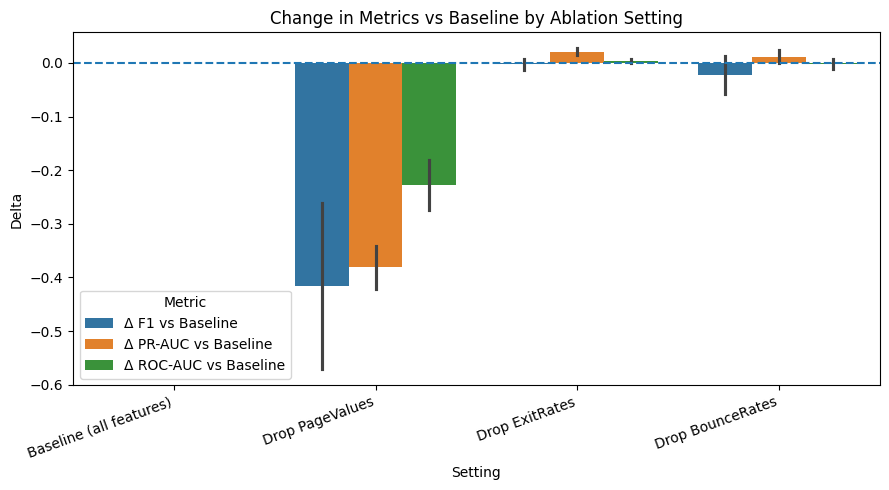

In [ ]:
## plotting how much each ablation hurts/helps relative to the baseline:
melted = results.melt(
    id_vars=["Setting", "Version"],
    value_vars=["Δ F1 vs Baseline", "Δ PR-AUC vs Baseline", "Δ ROC-AUC vs Baseline"],
    var_name="Metric",
    value_name="Delta"
)

plt.figure(figsize=(9, 5))
sns.barplot(data=melted, x="Setting", y="Delta", hue="Metric")
plt.axhline(0, linestyle="--")
plt.title("Change in Metrics vs Baseline by Ablation Setting")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()
